## Introduction to Craters on Planetary Surfaces

Cratering is an important process that has altered the surface topography of the Earth, other terrestrial and icy planets, and both rocky and icy moons, within our solar system and probaby others. That is - cratering is quite a uniform process. However, although we understand the process of cratering quite well, we only have a limited understanding about how a cratered surface influences the role of other surface processes. For example, on heavily cratered surfaces of the Moon, Mars, and Mercury, which have not been altered by plate tectonics like on Earth, how do the craters affect the flow and collection of water? of wind? and of the sediments transported by water and wind? These are funamental questions in our understanding of planetary bodies. Looking at the surfaces of the 4 rocky planets in our solar system, Earth is the odd one out, with topography dominated by mountains and basins created by plate tectonics. Based on this knowledge, what do you expect other planetary surfaces in other solar systems would look like, cratered or Earth-like? 


#### Learning objectives
_Skills_
* Create functions that generate crater morphologies using simple known laws
* Make changes to input parameters to vary the distribution and size of crater populations
* Use of LandLab model grids and components to route any kind of flow over the model surface
* Gain hands-on experience with visualizing data in Python

_Key concepts_
* Explore and understand the process of simulation of craters on a landscape
* Explore how an initially cratered landscape is affected by hillslope diffusion and the flow of surface water




In this notebook, we also use a Landlab model grid to simulate topography, you can see more about Landlab [here](https://landlab.github.io/#/).

In [1]:
import numpy as np
from landlab import RasterModelGrid, imshow_grid, NodeStatus, values
import random as random
import matplotlib.pyplot as plt

## How do we simulate crater location and size?

The size and location of a crater is somewhat random, but to constrain it in numerical models, we "pick" numbers randomly from a given probability distribution.   

#### Randomly Selecting Crater Locations

In this model, we pick crater loctions randomly from a  "uniform" distribution, that is, each location has an equally probable chance of having a crater. For example, in the code below we pick an x-coordinate and y-coordinate at random from a uniform distribution using the numpy.random.randint function which generates a random integer from a given minimum to a given maximum:

In [2]:
cratercenter = (np.random.randint(1, 10), np.random.randint(1, 10))
print("(x, y) = ", cratercenter)

(x, y) =  (7, 8)


If we generate many crater centers and plot the x and y coordinates as a histogram you can see there are _roughly_ equal numbers of each number but this is not a perfect fit as there is some "noise" as we randomly selected from this distribution

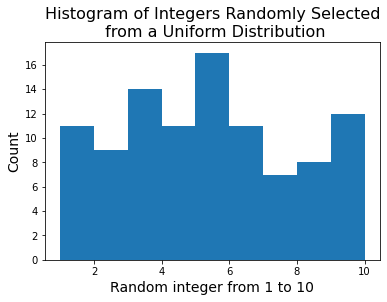

In [9]:
cratercenters = [np.random.randint(1, 11) for i in range(100)]

plt.hist(cratercenters, bins = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]);
plt.xlabel("Random integer from 1 to 10", fontsize = 14);
plt.ylabel("Count", fontsize = 14);
plt.title("Histogram of Integers Randomly Selected\n from a Uniform Distribution", fontsize = 16);

#### Randomly Selecting Crater Diameters

For crater size, we do not choose from a random distribution because there are actually different probabilities for different crater sizes. 
* Larger meteorites are less common, and more likely to break up in the atmosphere, so they are less likely to create craters at the surface. 
* Medium to small meteorites are more common and correspondingly so are their craters, 
* But, very small meteorites, although very common, are not likely to make it to the surface as they burn up in the atmosphere - even if it is incredibly thin like on Mars. 

Here we ignore very small craters (<1 km) as in a landscape evolution model we would likely be looking at medium to large scales (>> 1 km), and this simplifies the probability distribution to a **cumulative probability distribtuion** (Figure). Where the number of craters, ND, of diameter, D, that form is related to two scaling factors, Kx and an exponent $ \delta $:

$ N_D = K_x    D^{- \delta} $  

For Mars it has been estimated that: 

$ K_x $ = 1.0

and

$ \delta $ = 2.0 

In reality we implement this as shown in the code below, by using the "number of craters of a given diameter (Nd)" as a probability weight for that diameter, and we select the crater diameter randomly from a probability distribution of how many of that given diameter's craters there should be: 

In [13]:
Kx = 1.0  # Scaling coefficient
delta = 2.0  # km, scaling exponent
# Ncraters = 2 # Number of craters to add

minD = 1 #1 km
maxD =  50 # 50 km

diameter = list(range(minD, maxD)) ## make a list of all the possible diameters, from minD to maxD

NumberDs = [] #This step is required before the loop to instantiate a list which will hold our output
for D in range(minD, maxD): #for each diameter from 1 km to 50 km
    NumberD = Kx * D ** - delta #calculate the number of craters of that diameter that there should be
    NumberDs.append(NumberD) #append the number to a list of all the "numbers" of craters for each diameter, from 1 to 50 km
    

def weighted_choice_sub(weights):
    ''' randomly generate a number and see which weight number in the input list it falls under,
    return the index of that weight '''
    rnd = np.random.random() * sum(weights)
    for i, w in enumerate(weights):
        rnd -= w
        if rnd < 0:
            return i #return the index of the weight, which corresponds to the index of the diameter in a "partner" list


D_index = weighted_choice_sub(NumberDs);
print("Randomly selected diameter: {} km".format(diameter[D_index]));
## You can run the above cell a few times - what is the most commonly printed diameter or diameter range?


Randomly selected diameter: 1 km


If we generate many crater diameters and plot them as a histogram you can see there are more small craters and the number of craters of larger and larger diameters decreases, but this is not a perfect fit as there is some "noise" as we **_randomly_** selected from this distribution:

In [14]:
craterdiameters = [diameter[weighted_choice_sub(NumberDs)] for i in range(100)]

plt.hist(craterdiameters, bins = 10, range = (minD, maxD));
plt.xlabel("Crater Diameter from {} km to {} km".format(minD, maxD), fontsize = 14);
plt.ylabel("Count", fontsize = 14);
plt.title("Histogram of Crater Diameters Randomly Selected\n from a Cumulative Probability Distribution", fontsize = 16);

## How do we simulate crater shape? 

Good question! 

Craters are recognized because of the characteristic bowl-like depression that transitions upwards into a crater rim, that is actually above the surrounding terrain and surrounded by an "ejecta blanket" of all the material excavated from the crater itself, and with distance away from the crater the rim slopes downwards and the ejecta blanket gets thinner, so their contributions to elevation get smaller and smaller. These changes in elevation can actually be described by mathematical equations such as an exponential function, or in our case, a power law. 

For a SIMPLE crater (bowl-like depression) with diameter, D (in m), on Mars, the elevation changes are:

$ H2 - H1 + H1 \frac{2r}{D}^{m} $ within the crater (ie. from radial distance = 0 to radial distance = crater radius) (1)

$ H2 \frac{2r}{D}^{-n} $ outside of the crater (ie. where radial distance > crater radius, to describe the ejecta blanket) (2) 


and where $ r $ is the radial distance from the crater center, and $ H1, H2, $ and the exponents $ m $ and $ n $ are:

$ H1 = 2.54 D ^{0.67} $

$  H2 = 1.93 D ^{0.52} $
  
$  m = 0.73 D ^{0.11} $ 

$ n  = 3 $


These equations can be modified slightly to reflect the shape of a Complex crater, although they still do not describe finer crater detail such a central uplift and terracing, which is usually not considered as part of landscape-scale simulations. 

See [Howard (2007)](https://doi.org/10.1016/j.geomorph.2007.04.017) for more information on simulating craters!

In [15]:
diameter = 40
radius = diameter/2
rs = np.arange(start=0, stop=radius*2, step=0.1) #create an array of radial distances from the crater center

H1 = 2.54*(diameter*1000)**0.67
H2 = 1.93*(diameter*1000)**0.52
m = 0.73*(diameter*1000)**0.11 
n = 3

incrater = rs[rs <= radius]
in_idx = np.where(rs <= radius)[0]
# equation for inside the crater
inDepth = (H2 - H1 + H1*((2*incrater)/(diameter))**m)/1000
# mg.at_node['topographic__elevation'][in_idx] += inDepth

outcrater = rs[rs >= radius]
out_idx = np.where(rs >= radius)[0]
# equation for outside the crater (ejecta!)
outDepth = (H2*((2*outcrater)/(diameter))**-n)/1000
# mg.at_node['topographic__elevation'][out_idx] += outDepth


fig, ax = plt.subplots(1, 2, dpi=250, facecolor='w', figsize=(10, 3))
# fig.suptitle("Representation of Crater Shape", fontsize = 16);
ax[0].plot(incrater/1000, inDepth, 'k', label = 'Inside Crater');
ax[0].plot(outcrater/1000, outDepth, 'r', label = 'Outside Crater (ejecta)');
ax[0].set_xlabel("Radial Distance from Center (km)", fontsize = 14);
ax[0].set_ylabel("Elevation (km)", fontsize =14 );
ax[0].set_title("Simple Crater")
ax[0].set_ylim(min(inDepth)-0.5, max(inDepth)+0.5)

## Lets also compare the shape of a complex crater! (for simplicity; the crater is of the same diameter as the one above)
H1 = 12.20*(diameter*1000)**0.49
H2 = 0.79*(diameter*1000)**0.6
m = 0.64*(diameter*1000)**0.13 
n = 3

# equation for inside the crater
inDepthC = (H2 - H1 + H1*((2*incrater)/(diameter))**m)/1000
# mg.at_node['topographic__elevation'][in_idx] += inDepth

# equation for outside the crater (ejecta!)
outDepthC = (H2*((2*outcrater)/(diameter))**-n)/1000
# mg.at_node['topographic__elevation'][out_idx] += outDepth

ax[1].plot(incrater/1000, inDepthC, 'k', label = 'Inside Crater');
ax[1].plot(outcrater/1000, outDepthC, 'r', label = 'Outside Crater (ejecta)');
ax[1].set_xlabel("Radial Distance from Center (km)", fontsize = 14);
ax[1].set_ylabel("Elevation (km)", fontsize =14 );
ax[1].legend(loc="best", fontsize=14);
ax[1].set_title("Complex Crater");
ax[1].set_ylim(min(inDepth)-0.5, max(inDepth)+0.5);

## Now with all of the cratering theory covered, let's make a cratered surface!

This tutorial uses Landlab model grids, a convenient library of modules for building model grids, with many components to then do landscape evolution on the grids! With some tweaks to the code, this cratering module would work just as well on a numpy array of elevation values. 

First, lets instantiate the Landlab model grid, with a field for elevation values called "topographic__elevation":

In [16]:
size = 200 #km
spacing = 1 #km
xy = int(size/spacing) #km
rf = 0.1 # how noisy we want the initial topography to be
Kx = 1.0  # Scaling coefficient
delta = 2.0  # km, scaling exponent

mg = RasterModelGrid((xy, xy), xy_spacing = spacing); #initiate surface; see above for variables
z = np.zeros(mg.number_of_nodes); # initiate a field which will be our elevation values

We can add some random noise to this surface to make it slightly more realistic. The "seed" here ensures that the added-randomness is the same everytime, to keep our model grid reproducible! 

In [17]:
np.random.seed(30) # Keep this constant (e.g., at 30) so the initial randomness it always the same
z += np.random.rand(mg.number_of_nodes)*rf  # make the noise large enough relative to crater
mg.add_field("topographic__elevation", z, at="node", units="km", copy=True, clobber=True);

It's very easy to visualize model grids with the inbuilt function, imshow_grid:

C:\Users\erb2734\Anaconda3\envs\espin\lib\site-packages\landlab\plot\imshow.py:267: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("pink").copy()
  cmap.set_bad(color=color_for_closed)
C:\Users\erb2734\Anaconda3\envs\espin\lib\site-packages\landlab\plot\imshow.py:307: MatplotlibDeprecationWarning: The 'norm' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases later.
  cb = plt.colorbar(norm=norm, shrink=shrink)


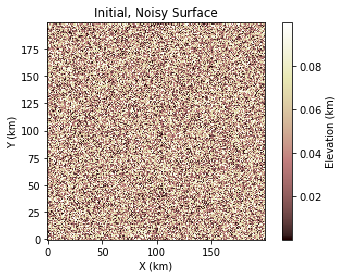

In [18]:
imshow_grid(mg, "topographic__elevation" , plot_name='Initial, Noisy Surface',
        var_name='Elevation', var_units='km', grid_units=('km', 'km')) #imshow(grid, value field)

### ADD SOME CRATERS!

First, we define everything as functions which allows us to easily re-do the cratering over and over without copying code

In [19]:
## Everything is packaged as functions: 
def crater_depth(d, diameter, mg, d_ref=7):
    """
    Define in and out of crater changes to topography.

    Parameters
    ----------
    d : np.ndarray
        Array of distances of nodes to the center of the crater.
        From `landlab.grid.raster.RasterModelGrid.calc_distances_of_nodes_to_point`
    diameter : int, float
        Diameter of the crater
    mg : landlab.grid.raster.RasterModelGrid
        Landlab raster model grid of the landscape

    d_ref: int, float
        Diameter at which craters transition from "simple" to "complex" structural type
        Default = 7 km (relevant to Mars)

    Returns
    -------
    mg : landlab.grid.raster.RasterModelGrid
        Landlab raster model grid after crater has modified the topography
    """
    radius = diameter/2
    diameter *= 1000
    d_ref *= 1000

    if diameter <= d_ref:
        H1 = 2.54*diameter**0.67
        H2 = 1.93*diameter**0.52
        m = 0.73*diameter**0.11  # value: 2 to 3

    elif diameter > d_ref:
        H1 = 12.20*diameter**0.49
        H2 = 0.79*diameter**0.6
        m = 0.64*diameter**0.13  # value: 2 to 3

    # Howard et al, 2007:
    # "The exponent n is constrained such that volume deposited on the rim
    # equals the volume excavated from the bowl and ranges from a value of
    # about 3 for a 7 km crater to 3.5 for a 250 km crater.""
    n = 3
    H2H1 = H2 - H1

    incrater = d[d <= radius]
    in_idx = np.where(d <= radius)[0]
    # equation for inside the crater
    inDepth = (H2H1 + H1*((2*(incrater*1000))/(diameter))**m)/1000 #In KM (hence /1000)
    mg.at_node['topographic__elevation'][in_idx] += inDepth

    outcrater = d[d > radius]
    out_idx = np.where(d > radius)[0]
    # equation for outside the crater (ejecta!)
    outDepth = (H2*((2*(outcrater*1000))/(diameter))**-n)/1000 # IN KM (hence /km)
    mg.at_node['topographic__elevation'][out_idx] += outDepth
    return mg


def do_cratering(Ncraters, NDs, minD, maxD, xy, mg, spacing):
    """
    Add craters to some landlab raster model.

    Parameters
    ----------
    Ncraters : int
        Number of craters that impact

    NDs : list
        List of weights for random sampling

    minD : int
        Minimum crater diameter

    maxD : int
        Maximum crater diameter

    xy : int
        Domain size (# cells) in one direction (domain is square)

    mg : landlab.grid.raster.RasterModelGrid
        Landlab raster model grid of the landscape

    Returns
    -------
    mg : landlab.grid.raster.RasterModelGrid
        Landlab raster model grid after craters have modified the topography

    """

    for i in range(Ncraters):  # For N number of craters
        a = weighted_choice_sub(NDs)
        diameter = list(range(minD, maxD))[a]
        cratercenter = (np.random.randint(1, xy*spacing), np.random.randint(1, xy*spacing))
        d = mg.calc_distances_of_nodes_to_point(cratercenter)

        crater_depth(d, diameter, mg, d_ref=7)

    return mg

Before running the functions, we need to define the variables we need: 

In [21]:
Ncraters = int(input("How many craters do you want to add? ")) # see console to add your own number!

minD = int(spacing * 3) # want it to be greater than spacing, three times the smallest cell
maxD = int((size)/4) #max diameter (m), a quarter of the total domain width
print("Minimum possible crater size:", minD, "km")
print("Maximum possible crater size:", maxD, "km")

NDs = []
for D in range(minD, maxD):
    ND = Kx * D ** - delta
    NDs.append(ND)

How many craters do you want to add? 100
Minimum possible crater size: 3 km
Maximum possible crater size: 50 km


and now, to run the code it's very simple given that we already defined the function "do_cratering":

In [22]:
random.seed(50) #Chose random seed number 50 (this ensures crater locations are same every time)
mg = do_cratering(Ncraters, NDs, minD, maxD, size, mg, spacing)

## Display the newly cratered surface!
imshow_grid(mg, "topographic__elevation", plot_name='Cratered Surface',
        var_name='Elevation', var_units='km', grid_units=('km', 'km'), cmap="Spectral_r")

C:\Users\erb2734\Anaconda3\envs\espin\lib\site-packages\landlab\plot\imshow.py:267: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("Spectral_r").copy()
  cmap.set_bad(color=color_for_closed)


Notice that if you rerun the code above, it will keep adding more craters to the surface. To "reset" it, rerun all the way from 4 cells above, where we initialize the noisy surface (= mg). 

#### This is some code that offers better visualisation of the data
* use LandLab "calc_hillshade_at_node" function to create a hillshade
* display the data as a hillshade with semi-transparent colored topography overlain
* and display a cross-section of elevation through the middle of the surface

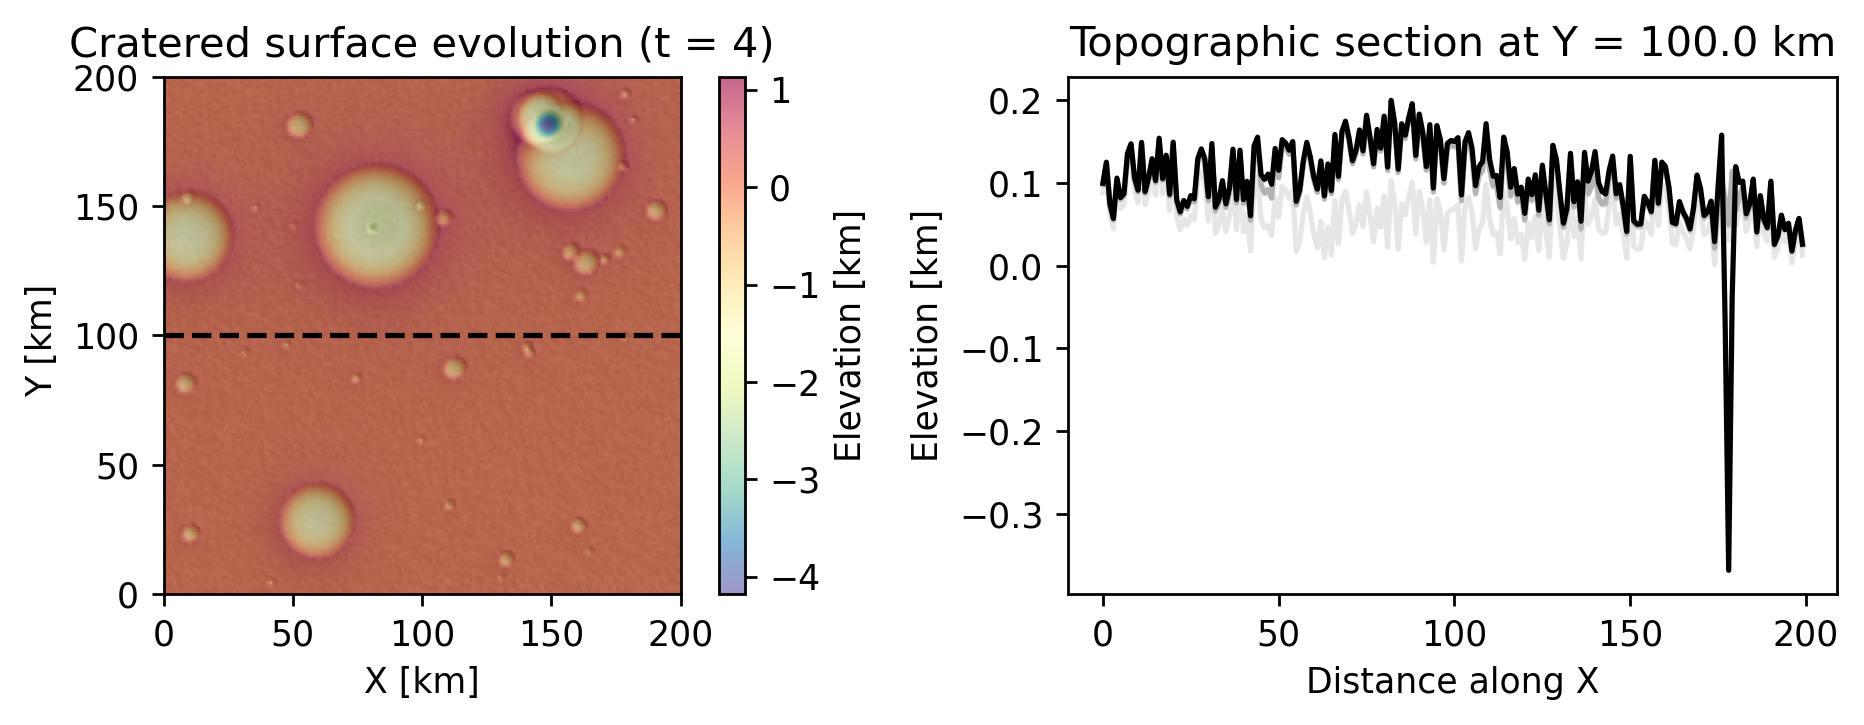

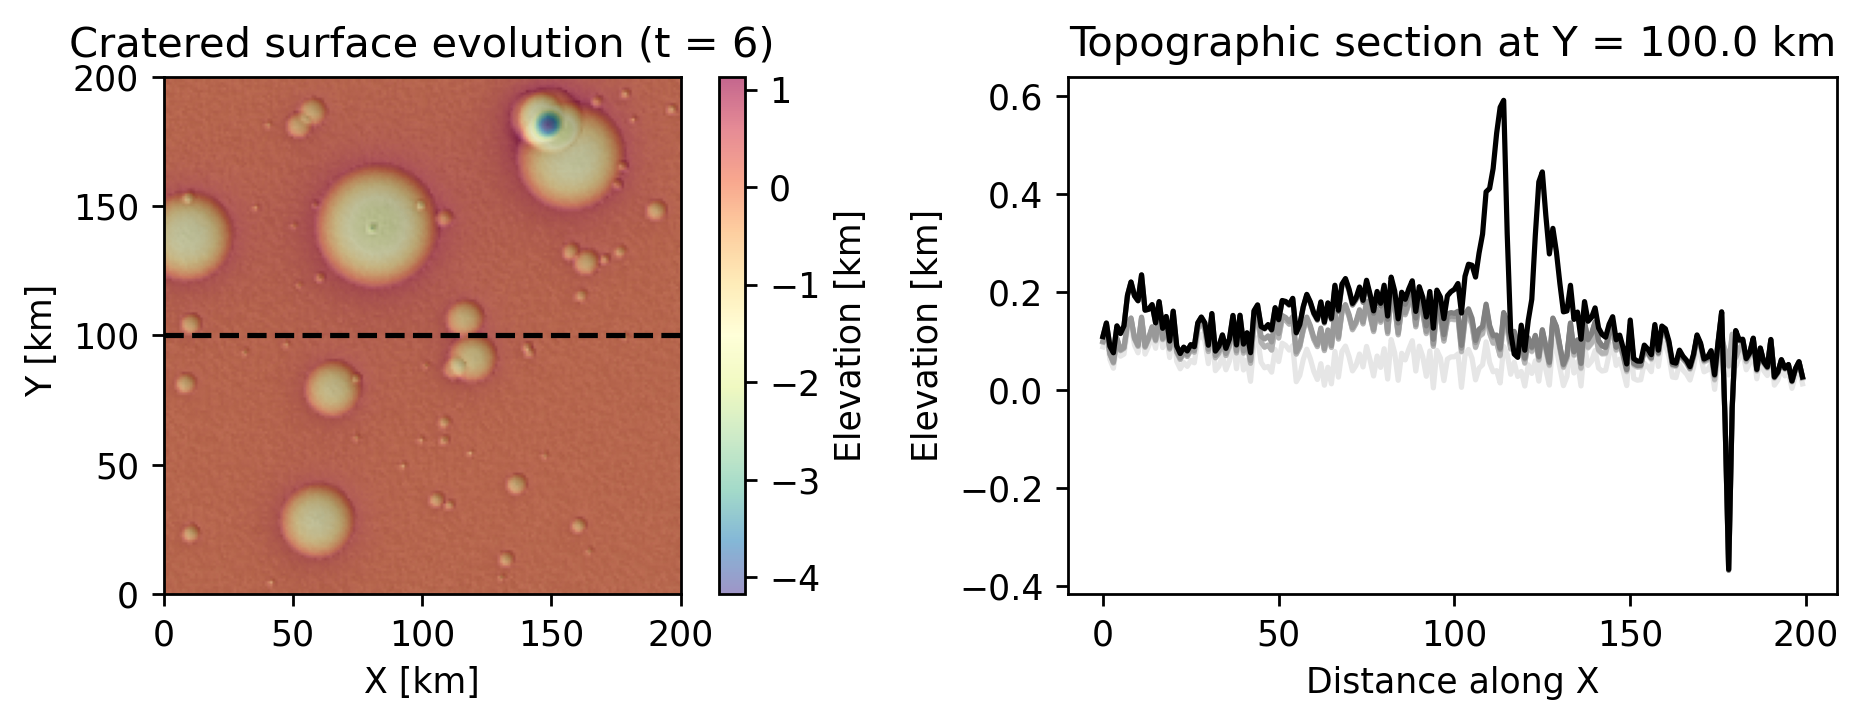

In [24]:
## This cell may take a while! don't worry... it's working!
size = 200
xy = int(size/spacing)
spacing = 1
rf = 0.1
Ncraters = 10 #number of cratesr by timestep

mg = RasterModelGrid((xy, xy), xy_spacing = spacing); #initiate surface; see above for variables
z = np.zeros(mg.number_of_nodes); # initiate a field which will be our elevation values
np.random.seed(30) # Keep this constant (e.g., at 30) so the initial randomness it always the same
z += np.random.rand(mg.number_of_nodes)*rf  # make the noise large enough relative to crater
mg.add_field("topographic__elevation", z, at="node", units="km", copy=True, clobber=True);

# Define where section is taken along y (in km)
stk_km = xy/2
stk = int(stk_km/spacing) #node location of stk_km
# Number of timesteps
nsteps = 10

cmap1 = "Greys"
cmap2 = "Spectral_r"

old_arr = np.zeros((nsteps, xy))

for i in range(1, nsteps):
    # crater landscape
    mg = do_cratering(Ncraters, NDs, minD, maxD, xy, mg, spacing)

    # update plot
    fig, ax = plt.subplots(1, 2, dpi=250, facecolor='w', figsize=(8, 3))
    topo = mg.field_values('node', 'topographic__elevation').reshape((xy, xy)) #create an array of elevation values across the mg domain
    hs = mg.calc_hillshade_at_node(elevs='topographic__elevation') #create a hillshade array
    hill = np.reshape(hs, (xy, xy)) #reshape the hillshade array to be the same shape as the topo array
    img1 = ax[0].imshow(hill, cmap=cmap1, alpha=1, extent = [0,size, 0, size], vmin=0, vmax=1)
    img2 = ax[0].imshow(topo, cmap=cmap2, alpha=0.6, extent = [0,size, 0, size])
    ax[0].set_title("Cratered surface evolution (t = %i)" %i)
    cbar = plt.colorbar(img2, fraction=0.045, ax=ax[0], label = "Elevation [km]")
    ax[0].set_xlabel('X [km]')
    ax[0].set_ylabel('Y [km] ')
    #stk = int(stk_km/spacing)
    ax[0].plot(np.linspace(0, size), np.ones_like(np.linspace(0, size))*stk_km,
               c='k', linestyle='--')
    ax[0].set_xlim([0, size])
    ax[0].set_ylim([0, size])

    ax[1].plot(topo[stk, :], c=[0, 0, 0], zorder=10)
    for j in range(old_arr.shape[0]):
        if np.sum(old_arr[j, :]) != 0:
            ax[1].plot(old_arr[j, :], c=[1-j/nsteps, 1-j/nsteps, 1-j/nsteps])
    ax[1].set_title('Topographic section at Y = ' + str(stk_km) + " km")
    ax[1].set_ylabel('Elevation [km]')
    ax[1].set_xlabel('Distance along X')
    ax[1].set_ylim() # I think making a dynamic scale is kind of fun, shows how much it changes? Instead of [zmin, zmax]

    plt.tight_layout()   

    # retain old array section
    old_arr[i, :] = topo[stk, :]

## How do the craters affect the flow and collection of water? 

Back to a question posed at the start of this notebook, how does the cratered landscape look with some diffusion? With some 'flowing water'? We can use pre-built Landlab components to explore this!

## Some Questions to Think About / Explore:
* What does advection (fluvial erosion) do to the cratered landscape? What happens when you differ some of the stream power coefficients? Look at the difference map, where is the most fluvial erosion taking place?
* What does diffusion do to the cratered landscape? What happens if you differ the diffusion coefficient? Look at the difference map, where is the most fluvial erosion taking place?
* How do the paths of water vary when the cratered landscape is diffused vs. not diffused? 

In [25]:
### Each time we initialise a new grid, to avoid using the already cratered grid which we'd just made above
size = 200
xy = int(size/spacing)
spacing = 1
rf = 0.1

mg = RasterModelGrid((xy, xy), xy_spacing = spacing); #initiate surface; see above for variables
z = np.zeros(mg.number_of_nodes); # initiate a field which will be our elevation values
np.random.seed(30) # Keep this constant (e.g., at 30) so the initial randomness it always the same
z += np.random.rand(mg.number_of_nodes)*rf  # make the noise large enough relative to crater
mg.add_field("topographic__elevation", z, at="node", units="km", copy=True, clobber=True);


In [26]:
## First, we add craters, as before:
# Ncraters = int(input("How many craters do you want to add per timestep? ")) # see console to add your own number!
Ncraters = 100 ## Set the number of craters to add to the surface

minD = int(spacing * 3) # want it to be greater than spacing, three times the smallest cell
print("Minimum possible crater size:", minD, "km")
maxD = int((size)/4) #max diameter (m), a quarter of the total domain width
print("Maximum possible crater size:", maxD, "km")

NDs = []
for D in range(minD, maxD):
    ND = Kx * D ** - delta
    NDs.append(ND)

random.seed(50) #Chose random seed number 50 (this ensures crater locations are same every time)
mg = do_cratering(Ncraters, NDs, minD, maxD, size, mg, spacing) ## This function is defined above

fig = plt.figure(dpi=250, facecolor='w', figsize=(8, 3));
topo = mg.field_values('node', 'topographic__elevation').reshape((xy, xy)); #create an array of elevation values across the mg domain
hs = mg.calc_hillshade_at_node(elevs='topographic__elevation'); #create a hillshade array
hill = np.reshape(hs, (xy, xy)); #reshape the hillshade array to be the same shape as the topo array
img1 = plt.imshow(hill, cmap=cmap1, alpha=1, extent = [0,size, 0, size], vmin=0, vmax=1);
img2 = plt.imshow(topo, cmap=cmap2, alpha=0.4, extent = [0,size, 0, size]);
plt.title("Cratered Surface");
cbar = plt.colorbar(img2, fraction=0.045, label = "Elevation [km]");
plt.xlabel('X [km]');
plt.ylabel('Y [km] ');
plt.xlim([0, size]);
plt.ylim([0, size]);
plt.tight_layout(); 

topo_initial = topo.copy()

Minimum possible crater size: 3 km
Maximum possible crater size: 50 km


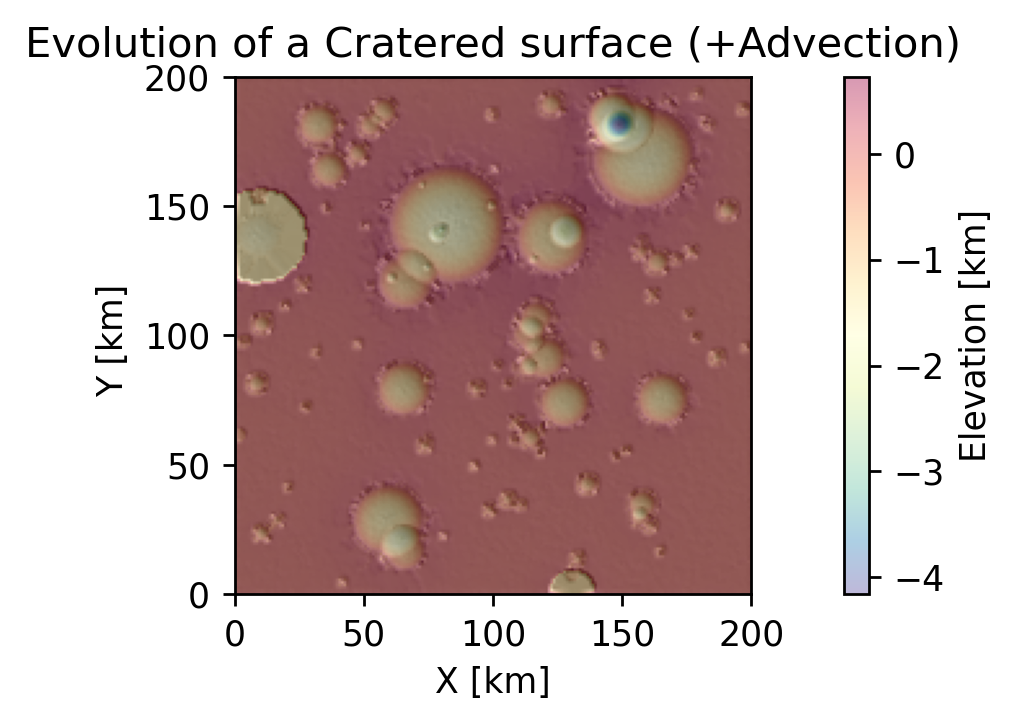

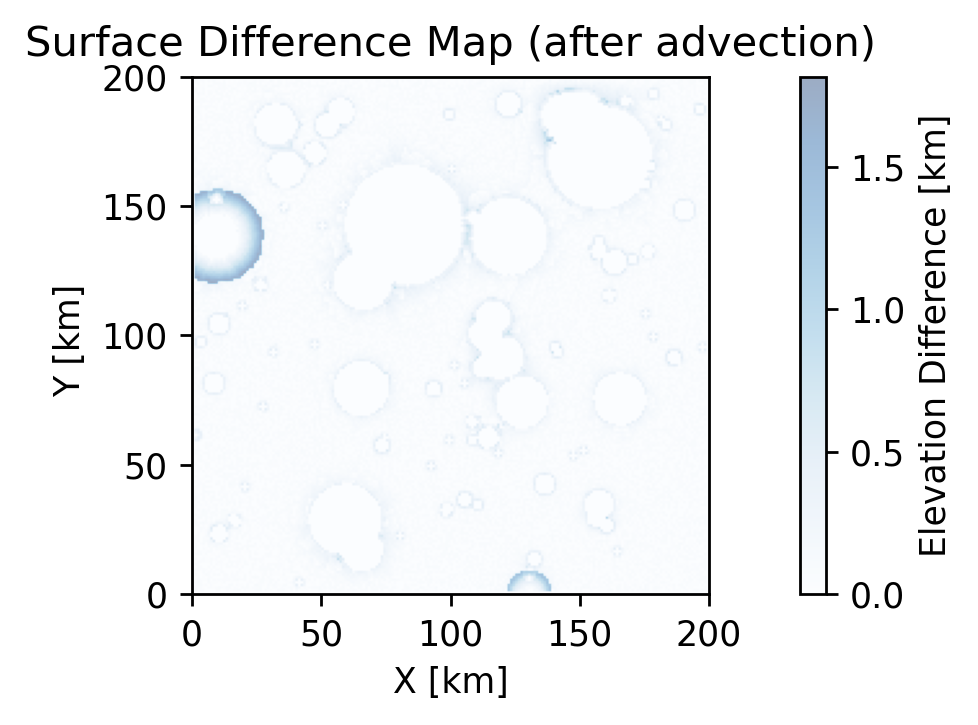

In [27]:
## This cell may take some time!
########### DIRECT SOME FLOW ACROSS LANDSCAPE ########
######################################################

## first import the modules needed from LandLab, you can read all about these on ReadTheDocs
from landlab.components import FlowDirectorSteepest, FlowAccumulator, FastscapeEroder, DepressionFinderAndRouter
from landlab.components import ChannelProfiler

## Set a consistent time step for the model runs
dt = 1000.0

fa = FlowAccumulator(mg, surface='topographic__elevation', flow_director='FlowDirectorD8', 
                     runoff_rate=None, depression_finder=DepressionFinderAndRouter, routing = 'D8');

fa.run_one_step()

sp = FastscapeEroder(mg, K_sp=1.0, m_sp=0.5, n_sp=1., threshold_sp=0, 
                     discharge_field="surface_water__discharge", erode_flooded_nodes = False)

sp.run_one_step(dt=dt)

fig = plt.figure(dpi=250, facecolor='w', figsize=(8, 3));
topo = mg.field_values('node', 'topographic__elevation').reshape((xy, xy)); #create an array of elevation values across the mg domain
hs = mg.calc_hillshade_at_node(elevs='topographic__elevation'); #create a hillshade array
hill = np.reshape(hs, (xy, xy)); #reshape the hillshade array to be the same shape as the topo array
img1 = plt.imshow(hill, cmap=cmap1, alpha=1, extent = [0,size, 0, size], vmin=0, vmax=1);
img2 = plt.imshow(topo, cmap=cmap2, alpha=0.4, extent = [0,size, 0, size]);
plt.title("Evolution of a Cratered surface (+Advection)");
cbar = plt.colorbar(img2, fraction=0.045, label = "Elevation [km]");
plt.xlabel('X [km]');
plt.ylabel('Y [km] ');
plt.xlim([0, size]);
plt.ylim([0, size]); 
plt.tight_layout();

## Plot a difference map
topo_diff = topo_initial - topo
fig2 = plt.figure(dpi=250, facecolor='w', figsize=(8, 3));
# img1 = plt.imshow(hill, cmap=cmap1, alpha=1, extent = [0,size, 0, size], vmin=0, vmax=1);
img2 = plt.imshow(topo_diff, cmap="Blues", alpha=0.4, extent = [0,size, 0, size]);
plt.title("Surface Difference Map (after advection)");
cbar = plt.colorbar(img2, fraction=0.045, label = "Elevation Difference [km]");
plt.xlabel('X [km]');
plt.ylabel('Y [km] ');
plt.xlim([0, size]);
plt.ylim([0, size]); 
plt.tight_layout();

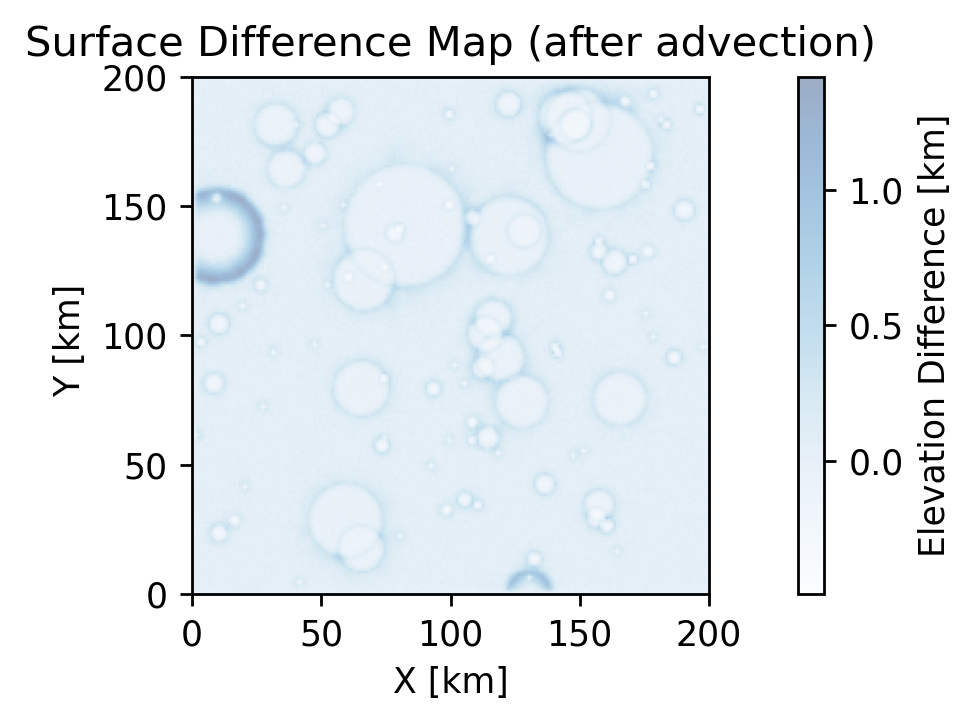

In [28]:
## Next: What happens if we diffuse the landscape first?
## This cell might take a while to run!
#########################

## First we should consider the boundary conditions, which boundaries should be open or closed?
## Here we have set all the boundaries as open
mg.set_closed_boundaries_at_grid_edges(False, False, False, False) #set all as open boundaries

## Import the module for Diffusion from Landlab. 
## There's different landlab modules for this which you can check out!
from landlab.components import LinearDiffuser

## Set up the linear diffuser model (ld), with a diffusivity coefficient
ld = LinearDiffuser(mg, linear_diffusivity=1)

#Then run the linear diffused model for one time step (of 100 seconds)
for i in range(1):
    ld.run_one_step(1.)

fig = plt.figure(dpi=250, facecolor='w', figsize=(8, 3));
topo = mg.field_values('node', 'topographic__elevation').reshape((xy, xy)); #create an array of elevation values across the mg domain
hs = mg.calc_hillshade_at_node(elevs='topographic__elevation'); #create a hillshade array
hill = np.reshape(hs, (xy, xy)); #reshape the hillshade array to be the same shape as the topo array
img1 = plt.imshow(hill, cmap=cmap1, alpha=1, extent = [0,size, 0, size], vmin=0, vmax=1);
img2 = plt.imshow(topo, cmap=cmap2, alpha=0.4, extent = [0,size, 0, size]);
plt.title("Evolution of a Cratered surface (+Diffusion)");
cbar = plt.colorbar(img2, fraction=0.045, label = "Elevation [km]");
plt.xlabel('X [km]');
plt.ylabel('Y [km] ');
plt.xlim([0, size]);
plt.ylim([0, size]); 
plt.tight_layout();

## Plot a difference map
topo_diff = topo_initial - topo
fig2 = plt.figure(dpi=250, facecolor='w', figsize=(8, 3));
# img1 = plt.imshow(hill, cmap=cmap1, alpha=1, extent = [0,size, 0, size], vmin=0, vmax=1);
img2 = plt.imshow(topo_diff, cmap="Blues", alpha=0.4, extent = [0,size, 0, size]);
plt.title("Surface Difference Map (after advection)");
cbar = plt.colorbar(img2, fraction=0.045, label = "Elevation Difference [km]");
plt.xlabel('X [km]');
plt.ylabel('Y [km] ');
plt.xlim([0, size]);
plt.ylim([0, size]); 
plt.tight_layout();

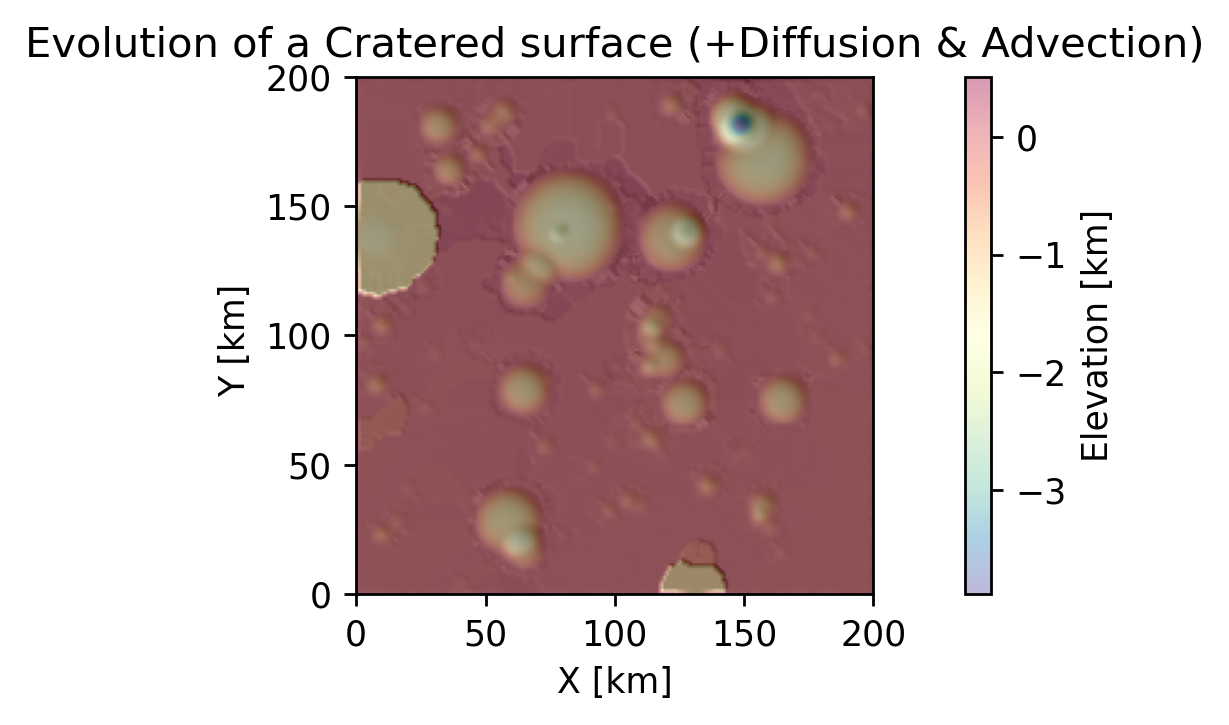

In [29]:
########### DIRECT SOME FLOW ACROSS LANDSCAPE ######## (Copied from above: repeat after diffusion of landscape)
######################################################

## first import the modules needed from LandLab, you can read all about these on ReadTheDocs
from landlab.components import FlowDirectorSteepest, FlowAccumulator, FastscapeEroder, DepressionFinderAndRouter
from landlab.components import ChannelProfiler

## Set a consistent time step for the model runs
dt = 1000.0

fa = FlowAccumulator(mg, surface='topographic__elevation', flow_director='FlowDirectorD8', 
                     runoff_rate=None, depression_finder=DepressionFinderAndRouter, routing = 'D8');

fa.run_one_step()

sp = FastscapeEroder(mg, K_sp=1.0, m_sp=0.5, n_sp=1., threshold_sp=0, 
                     discharge_field="surface_water__discharge", erode_flooded_nodes = False)

sp.run_one_step(dt=dt)

fig = plt.figure(dpi=250, facecolor='w', figsize=(8, 3));
topo = mg.field_values('node', 'topographic__elevation').reshape((xy, xy)); #create an array of elevation values across the mg domain
hs = mg.calc_hillshade_at_node(elevs='topographic__elevation'); #create a hillshade array
hill = np.reshape(hs, (xy, xy)); #reshape the hillshade array to be the same shape as the topo array
img1 = plt.imshow(hill, cmap=cmap1, alpha=1, extent = [0,size, 0, size], vmin=0, vmax=1);
img2 = plt.imshow(topo, cmap=cmap2, alpha=0.4, extent = [0,size, 0, size]);
plt.title("Evolution of a Cratered surface (+Diffusion & Advection)");
cbar = plt.colorbar(img2, fraction=0.045, label = "Elevation [km]");
plt.xlabel('X [km]');
plt.ylabel('Y [km] ');
plt.xlim([0, size]);
plt.ylim([0, size]); 
plt.tight_layout();

## Plot a difference map
topo_diff = topo_initial - topo
fig2 = plt.figure(dpi=250, facecolor='w', figsize=(8, 3));
# img1 = plt.imshow(hill, cmap=cmap1, alpha=1, extent = [0,size, 0, size], vmin=0, vmax=1);
img2 = plt.imshow(topo_diff, cmap="Blues", alpha=0.4, extent = [0,size, 0, size]);
plt.title("Surface Difference Map (after diffusion)");
cbar = plt.colorbar(img2, fraction=0.045, label = "Elevation Difference [km]");
plt.xlabel('X [km]');
plt.ylabel('Y [km] ');
plt.xlim([0, size]);
plt.ylim([0, size]); 
plt.tight_layout();